# Sistema de diagnóstico asistido por computadora para la detección de las fases iniciales de Alzheimer mediante MRI

El alzheimer es una enfermedad neurodegenerativa caracterizada por un deterioro progresivo de la memoria y otras funciones cognitivas. La enfermedad suele caracterizarse en 7 fases, aunque los síntomas no siempre se evolucionan igual. Las primeras 3 fases se dan de forma previa al desarrollo de la demencia, y las fases de la 4 a la 7 existe un desarrollo progresivo de demencia; a partir de la fase 5, un paciente requiere asistencia de tiempo completo.

1. ***Fase preclínica***: no se presentan síntomas cognitivos evidentes pero comienzan los cambios a nivel cerebral, y puede durar varios años hasta que los síntomas aparezcan.
2. ***Fase inicial o leve***: etapa prodrómica, comienzan a desarrollarse problemas con la memoria que suelen ser confundidos como naturales por la vejez. El paciente puede continuar con una vida relativamente normal y realizar actividades cotidianas sin ayuda.
3. ***Fase moderada***: MCI, los problemas de memoria a corto plazo comienzan a ser evidentes, algunos pacientes comienzan a olvidar información importante. El deterioro cognitivo comienza a agravarse se presentan cambios bruscos de comportamiento y personalidad. El paciente requiere de un apoyo creciente para realizar actividades cotidianas.
4. ***Fase moderadamente severa***: la pérdida de memoria es significativas y los pacientes tienen dificultades para reconocer a familiares y amigos cercanos. Las habilidades cognitivas se deterioran, la asistencia requerida para la vida diaria es casi necesaria para cualquier actividad, las habilidades comunicativas se deterioran significativamente.
5. ***Fase severa***: existe una pérdida grave de memoria y habilidades cognitivas. Los individuos pueden perder la capacidad de comunicación coherente y requieren de asistencia completa. Los cambios en la personalidad y el comportamiento son muy pronunciados, y la movilidad comienza a verse afectada.
6. ***Fase muy severa***: demencia, la asistencia es esencial para la vida del paciente, la capacidad para interactuar con el entorno y otras personas es muy limitada. La movilidad está gravemente afectada y el paciente puede quedar postrado en cama. Los cuidados paliativos pueden ser necesarios en esta etapa de la enfermedad.
7. ***Fase terminal***: desaparece la habilidad para la interacción con el entorno y otras personas. Los pacientes dependen completamente de sus cuidadores, se desarrolla incontinencia y puede perderse la capacidad de deglutir. La atención en esta etapa se centra en el confort y la calidad de vida, ya que la enfermedad ha progresado a su punto más severo.

La Imagen por Resonancia Magnética (MRI, por sus siglas en inglés) es una herramienta fundamental en la detección temprana del Alzheimer, ya que permite visualizar cambios estructurales en el cerebro antes de que los síntomas clínicos sean evidentes. A diferencia de otros métodos de diagnóstico, como evaluaciones neuropsicológicas o biomarcadores en líquido cefalorraquídeo, la MRI ofrece una evaluación no invasiva del cerebro, proporcionando imágenes detalladas de su morfología y posibles alteraciones.

El modelo propuesto se centra en las etapas iniciales de la enfermedad en donde los síntomas pueden pasar desapercibidos, ya que una temprana detección de la enfermedad se traduce en una mejor planificación lo que puede garantizar una mejor calidad de vida para el paciente y sus familiares durante las fases avanzadas del alzheimer.

## Importación de dependencias y preparación de entorno

In [ ]:
# Preparación del entorno
import kagglehub
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importación de dependencias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

## Exploración y Preprocesamiento del Dataset

### Cargar el Dataset con Aumentación de Datos

In [ ]:
# Descargar y cargar datos de Kaggle
dataset_path = kagglehub.dataset_download('uraninjo/augmented-alzheimer-mri-dataset')
image_dir = Path(os.path.join(dataset_path, "AugmentedAlzheimerDataset"))

# Creación de dataframe con etiquetas
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.JPG'))
labels = [os.path.split(os.path.split(x)[0])[1] for x in filepaths]

image_df = pd.DataFrame({
    'filepath': pd.Series(filepaths).astype(str),
    'label': pd.Series(labels)
})

# Codificar etiquetas
unique_labels = sorted(image_df['label'].unique())
image_df['label_idx'] = image_df['label'].map({label: idx for idx, label in enumerate(unique_labels)})

100%|██████████| 380M/380M [00:05<00:00, 66.8MB/s]

Extracting files...


In [ ]:
# Primera división: separar 70% train y 30% temporal (que será dividido en val y test)
train_df, temp_df = train_test_split(image_df,
                                    test_size=0.3,
                                    stratify=image_df['label_idx'],
                                    random_state=42)

# Segunda división: separar el 30% temporal en 15% val y 15% test (50%/50% del temporal)
val_df, test_df = train_test_split(temp_df,
                                  test_size=0.5,
                                  stratify=temp_df['label_idx'],
                                  random_state=42)

# Crear datasets a partir de los dataframes
train_ds = tf.data.Dataset.from_tensor_slices((train_df['filepath'].values, train_df['label_idx'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['label_idx'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['filepath'].values, test_df['label_idx'].values))

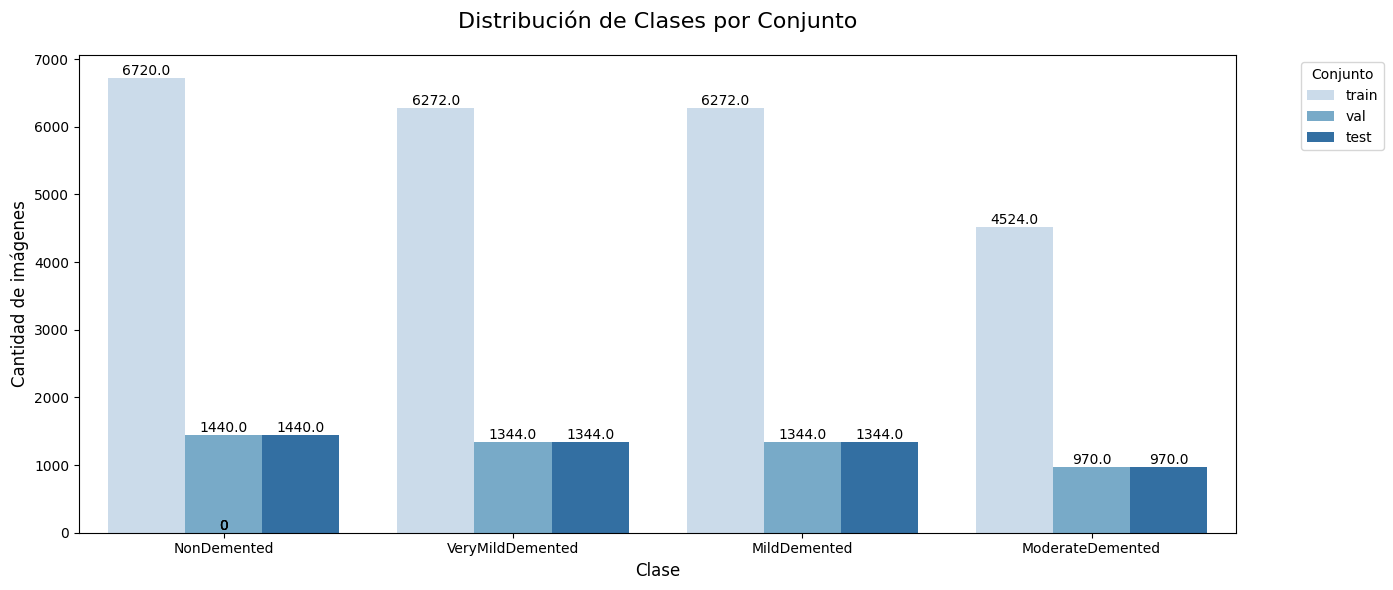


Conteo de imágenes por conjunto:
split
train    23788
test      5098
val       5098
Name: count, dtype: int64

Distribución por clase y conjunto:
split             test  train   val
label                              
MildDemented      1344   6272  1344
ModerateDemented   970   4524   970
NonDemented       1440   6720  1440
VeryMildDemented  1344   6272  1344


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Añadir columna 'split' al dataframe original
image_df['split'] = 'train'  # Inicializar todo como train
image_df.loc[val_df.index, 'split'] = 'val'  # Marcamos validación
image_df.loc[test_df.index, 'split'] = 'test'  # Marcamos test

# Configuración del estilo con fondo blanco
plt.style.use('default')  # Estilo por defecto (fondo blanco)
plt.figure(figsize=(14, 6), facecolor='white')  # Fondo blanco explícito

# Orden de clases
class_order = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
palette = sns.color_palette("Blues", 3)  # Paleta para train/val/test

# Gráfico de barras agrupadas
ax = sns.countplot(data=image_df, x='label', hue='split',
                  order=class_order,
                  hue_order=['train', 'val', 'test'],
                  palette=palette)

# Configuración del gráfico
plt.title('Distribución de Clases por Conjunto', fontsize=16, pad=20)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Cantidad de imágenes', fontsize=12)
plt.legend(title='Conjunto', bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir etiquetas de valor
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
               (p.get_x() + p.get_width() / 2., p.get_height()),
               ha='center', va='center',
               xytext=(0, 5),
               textcoords='offset points',
               fontsize=10)

# Asegurar fondo blanco
ax.set_facecolor('white')
plt.gcf().set_facecolor('white')

plt.tight_layout()
plt.show()

# Mostrar conteos por split
print("\nConteo de imágenes por conjunto:")
print(image_df['split'].value_counts())

print("\nDistribución por clase y conjunto:")
print(pd.crosstab(image_df['label'], image_df['split']))

In [ ]:
len(train_df), len(val_df), len(test_df)

(23788, 5098, 5098)

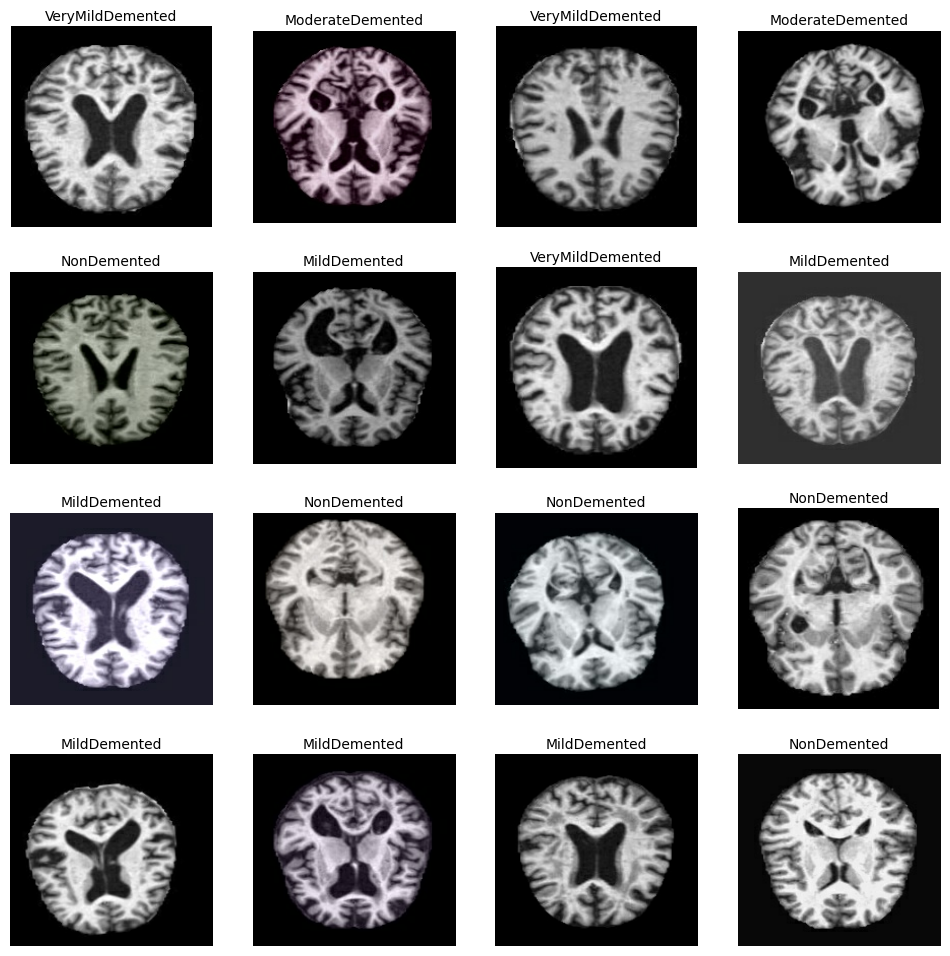

In [ ]:
# Configurar semilla para reproducibilidad
np.random.seed(42)

# Crear grid de 4x4
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Seleccionar 16 índices aleatorios
random_indices = np.random.choice(len(image_df), 16, replace=False)

# Mostrar imágenes con preprocesamiento similar al modelo
for i, idx in enumerate(random_indices):
    ax = axes[i//4, i%4]

    # Cargar imagen como tensor y convertir a numpy array
    img = tf.io.read_file(image_df.filepath.iloc[idx])
    img = tf.image.decode_jpeg(img, channels=3).numpy().squeeze()

    # Mostrar imágenes
    ax.imshow(img, vmin=0, vmax=255)
    ax.set_title(image_df.label.iloc[idx], fontsize=10, pad=4)
    ax.axis('off')

plt.show()

In [ ]:
# Preprocesamiento de las imágenes
def process_path(filepath, label):
    img = tf.io.read_file(filepath)                   # obtención de imágen desde la ruta
    img = tf.image.decode_jpeg(img, channels=1)       # cambio de RGB a escala de grises
    img = tf.image.resize(img, (128, 128))            # reducción de tamaño a 128 x 128 px
    return tf.cast(img, tf.float32) / 255.0, label    # normalización [0,1]

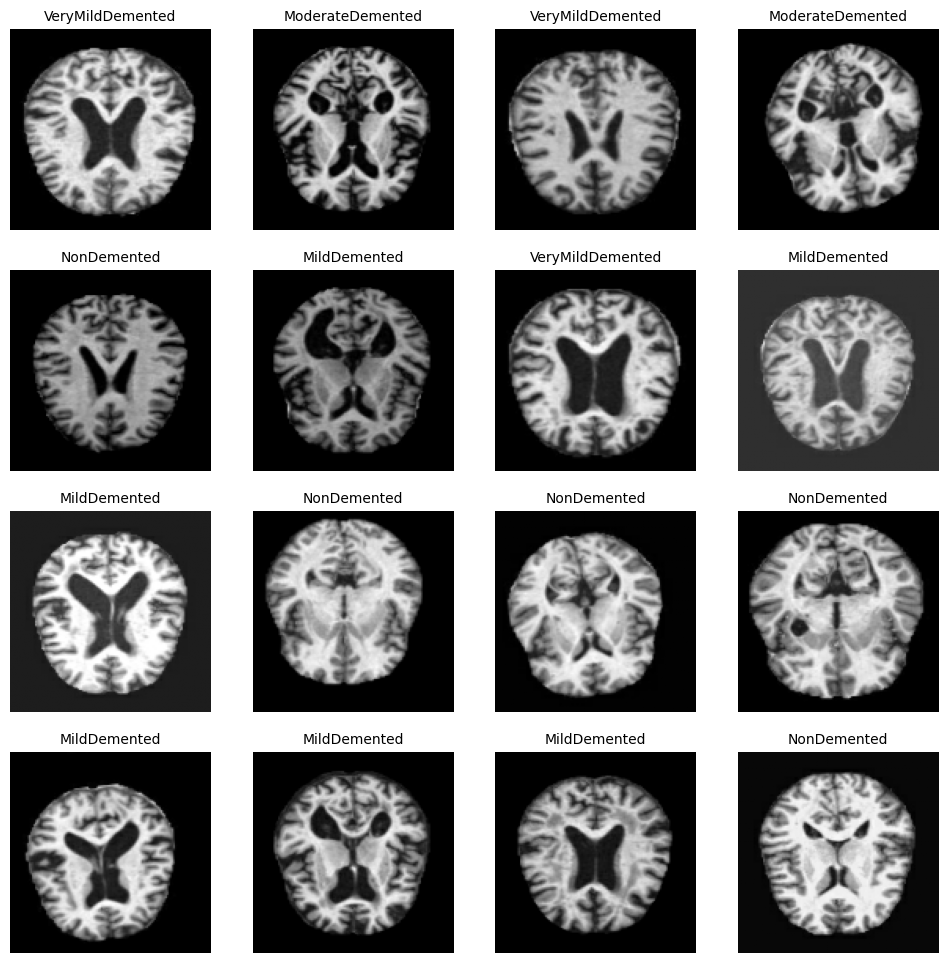

In [ ]:
# Visualización de imágenes preprocesadas
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, idx in enumerate(random_indices):
    ax = axes[i//4, i%4]

    # Usar función process_path
    img, _ = process_path(image_df.filepath.iloc[idx], None)

    # Mostrar con cmap='gray' para visualización correcta
    ax.imshow(img.numpy().squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(image_df.label.iloc[idx], fontsize=10)
    ax.axis('off')

plt.show()

In [ ]:
train_ds = train_ds.map(process_path).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path).batch(32).prefetch(tf.data.AUTOTUNE)

## Diseño del Modelo

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),   # ±5% de rotación
    layers.RandomZoom(0.1),        # Zoom 10%
    layers.RandomContrast(0.1),    # Contraste variable
    layers.RandomFlip("horizontal")
])

In [ ]:
model_02 = tf.keras.models.Sequential([
  # First Block
  data_augmentation,

  layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,1)),
  layers.BatchNormalization(),
  layers.Conv2D(32, (3,3), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2),
  layers.SpatialDropout2D(0.2),

  # Second Block
  layers.Conv2D(64, (3,3), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
  layers.BatchNormalization(),
  layers.Conv2D(64, (3,3), activation = 'relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2),
  layers.SpatialDropout2D(0.3),

  # Third Block
  layers.Conv2D(128, (3,3), activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
  layers.BatchNormalization(),
  layers.Conv2D(128, (3,3), activation = 'relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(2,2),
  layers.SpatialDropout2D(0.4),

  # Classification Block
  layers.Flatten(),
  layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(4, activation = 'softmax')
])

## Entrenamiento del modelo

In [ ]:
model_02.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks para early stopping y reducción de LR
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3, #antes teniamos 5
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

In [ ]:
# Entrenamiento
history_02 = model_02.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.3790 - loss: 1.7529 - val_accuracy: 0.5991 - val_loss: 1.0311 - learning_rate: 0.0010
Epoch 2/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 74s 91ms/step - accuracy: 0.5334 - loss: 1.1587 - val_accuracy: 0.6414 - val_loss: 0.9208 - learning_rate: 0.0010
Epoch 3/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.5887 - loss: 1.0479 - val_accuracy: 0.5973 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 4/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.6146 - loss: 1.0178 - val_accuracy: 0.6767 - val_loss: 0.8992 - learning_rate: 0.0010
Epoch 5/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 68s 91ms/step - accuracy: 0.6262 - loss: 1.0210 - val_accuracy: 0.7020 - val_loss: 0.8979 - learning_rate: 0.0010
Epoch 6/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.6454 - loss: 1.0321 - val_accuracy: 0.7317 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 7/30
744/744 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.6607 - l

In [ ]:
model_02.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 58, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 58, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d_1                  │ (None, 29, 29, 64)          │               0 │
│ (SpatialDropout2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │              

 Total params: 15,024,558 (57.31 MB)

 Trainable params: 5,007,716 (19.10 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 10,015,434 (38.21 MB)

## Evaluación del modelo

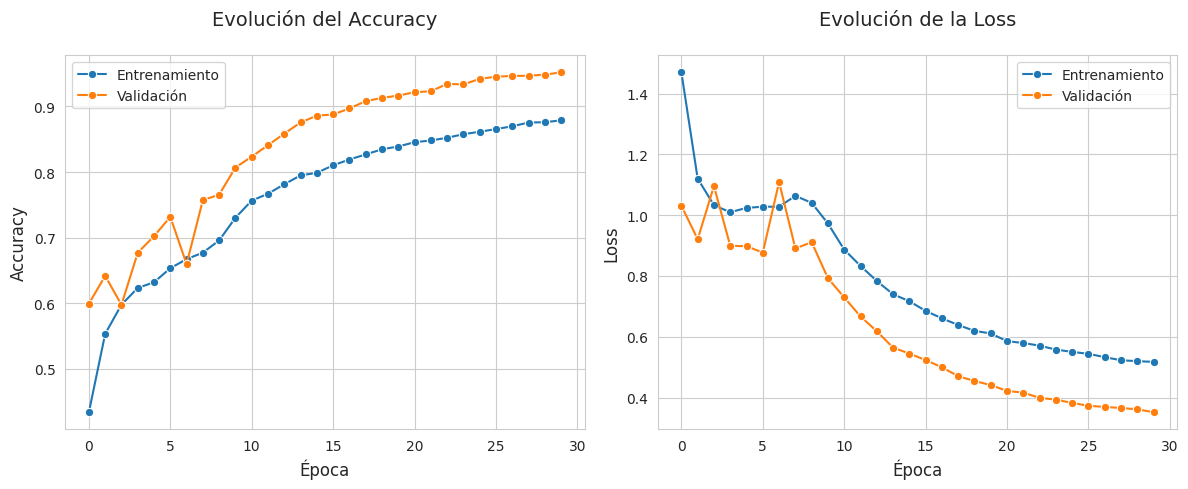

In [ ]:
# Métricas de Rendimiento
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# Accuracy
plt.subplot(1, 2, 1)
sns.lineplot(data=history_02.history['accuracy'], label='Entrenamiento', marker='o')
sns.lineplot(data=history_02.history['val_accuracy'], label='Validación', marker='o')
plt.title('Evolución del Accuracy\n', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Loss
plt.subplot(1, 2, 2)
sns.lineplot(data=history_02.history['loss'], label='Entrenamiento', marker='o')
sns.lineplot(data=history_02.history['val_loss'], label='Validación', marker='o')
plt.title('Evolución de la Loss\n', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.tight_layout()
plt.show()

744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step


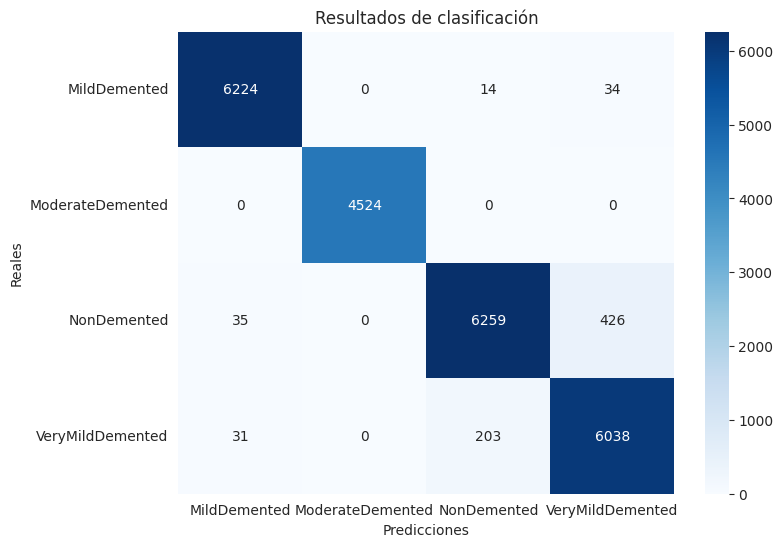

'\nTenemos que hacer una división que incluya test\nTrain 70%, Validation 15%, Test 15%\nTrain 80%, Validation 10%, Test 10%\n'

In [ ]:
# Matriz de confusión
predictions = model_02.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)
plt.title('Resultados de clasificación')
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.show()

In [ ]:
# Reporte de clasificación

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# Obtener las predicciones del modelo
y_pred = model_02.predict(test_ds).argmax(axis=1)

# Obtener las etiquetas reales
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calcular métricas
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Mostrar métricas
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Reporte de clasificación detallado
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=unique_labels))

744/744 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step
Precision: 0.9691
Recall: 0.9688
F1-Score: 0.9688

Reporte de Clasificación:
                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      6272
ModerateDemented       1.00      1.00      1.00      4524
     NonDemented       0.97      0.93      0.95      6720
VeryMildDemented       0.93      0.96      0.95      6272

        accuracy                           0.97     23788
       macro avg       0.97      0.97      0.97     23788
    weighted avg       0.97      0.97      0.97     23788



## Exportación del Modelo

In [ ]:
# Guardar el modelo
import keras
keras.saving.save_model(model_02, 'alzheimer_model_divided.keras')

# Cargar el modelo
# import keras
# model_02_loaded = keras.saving.load_model('alzheimer_model.keras')
# model_02_loaded.summary()